In [1]:
pip install datasets torch torchvision scikit-learn matplotlib wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


##### **IMPORT LIBRARIES**

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from datasets import load_dataset
import wandb

##### **INITIALIZE WANDB CONFIG**

In [ ]:
wandb.init(project="trashnet-classification", config={
    "learning_rate": 0.001,
    "batch_size": 32,
    "epochs": 20
})

config = wandb.config

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# TRAINED ON GOOGLE COLAB PRO L4 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# LOAD DATASET
ds = load_dataset("garythung/trashnet")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

dataset-original.zip:   0%|          | 0.00/3.63G [00:00<?, ?B/s]

dataset-resized.zip:   0%|          | 0.00/42.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5054 [00:00<?, ? examples/s]

#### **DATASET PREPARATION**

In [ ]:
# DEFINE CUSTOM DATASET CLASS
class TrashNetDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.data = dataset
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]["image"]
        label = self.data[idx]["label"]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# DEFINE TRANSFORMS
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
])

In [ ]:
# PREPARE DATASET
dataset = TrashNetDataset(ds["train"], transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

#### **MODEL ARCHITECTURE**

In [ ]:
# DEFINE THE CNN MODEL 
class TrashNetCNN(nn.Module):
    def __init__(self, num_classes):
        super(TrashNetCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [ ]:
# MODEL, LOSS, OPTIMIZER
model = TrashNetCNN(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

#### **MODEL TRAINING**

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# TRAINING LOOP
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())  

        train_accuracy = 100 * correct / total
        train_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        train_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        train_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        # LOG TO WANDB
        wandb.log({"Train Loss": train_loss / len(train_loader), "Train Accuracy": train_accuracy,
                   "Train Precision": train_precision, "Train Recall": train_recall, "Train F1 Score": train_f1})

        # VALIDATION STEP
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        val_preds = []
        val_labels = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_accuracy = 100 * correct / total
        val_precision = precision_score(val_labels, val_preds, average='macro', zero_division=0)
        val_recall = recall_score(val_labels, val_preds, average='macro', zero_division=0)
        val_f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)

        # LOG TO WANDB
        wandb.log({"Validation Loss": val_loss / len(val_loader), "Validation Accuracy": val_accuracy,
                   "Validation Precision": val_precision, "Validation Recall": val_recall, "Validation F1 Score": val_f1})

        # PRINT PROGRESS
        print(f"Epoch [{epoch+1}/{epochs}]")
        print(f"Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}")
        print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%, "
              f"Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}, "
              f"Validation F1: {val_f1:.4f}\n")

# TRAIN THE MODEL
train_model(model, train_loader, val_loader, criterion, optimizer, config.epochs)

Epoch [1/20]
Train Loss: 4.4171, Train Accuracy: 36.28%, Train Precision: 0.3205, Train Recall: 0.3325, Train F1: 0.3216
Validation Loss: 1.3024, Validation Accuracy: 52.03%, Validation Precision: 0.4479, Validation Recall: 0.4508, Validation F1: 0.4461

Epoch [2/20]
Train Loss: 1.5404, Train Accuracy: 41.01%, Train Precision: 0.3540, Train Recall: 0.3595, Train F1: 0.3486
Validation Loss: 1.3262, Validation Accuracy: 50.74%, Validation Precision: 0.4374, Validation Recall: 0.4371, Validation F1: 0.4331

Epoch [3/20]
Train Loss: 1.4842, Train Accuracy: 45.68%, Train Precision: 0.4323, Train Recall: 0.3982, Train F1: 0.3956
Validation Loss: 1.3706, Validation Accuracy: 50.45%, Validation Precision: 0.4081, Validation Recall: 0.4348, Validation F1: 0.4137

Epoch [4/20]
Train Loss: 1.4357, Train Accuracy: 46.01%, Train Precision: 0.4323, Train Recall: 0.4002, Train F1: 0.4002
Validation Loss: 1.2480, Validation Accuracy: 54.40%, Validation Precision: 0.5407, Validation Recall: 0.4436, Val

#### **MODEL EVALUATION** 

###### **NOTE: ALTHOUGH THE FULL COMPLETE CHARTS CAN BE ACCESSED THROUGH WANDB DASHBOARD, I GENERATED IT HERE AS WELL FOR MY OWN REFERENCES**

In [ ]:
# EXTRACT METRICS INTO LIST
train_losses = [
    4.4171, 1.5404, 1.4842, 1.4357, 1.3435, 1.3460, 1.3475, 1.3158, 1.2476, 1.2494,
    1.2392, 1.1943, 1.2305, 1.2186, 1.1522, 1.1068, 1.1137, 1.1264, 1.0962, 1.1455
]
train_accuracies = [
    36.28, 41.01, 45.68, 46.01, 49.84, 49.79, 49.67, 51.30, 53.75, 53.99,
    55.35, 56.37, 55.31, 55.97, 57.88, 59.16, 59.16, 59.24, 59.58, 57.66
]
val_losses = [
    1.3024, 1.3262, 1.3706, 1.2480, 1.2094, 1.7188, 1.2049, 1.0455, 1.5109, 1.3194,
    1.5837, 1.0652, 1.0510, 0.9597, 1.0852, 0.9868, 1.0512, 1.5296, 0.9912, 1.2195
]
val_accuracies = [
    52.03, 50.74, 50.45, 54.40, 54.60, 54.50, 57.86, 61.82, 53.91, 57.47,
    50.84, 60.63, 64.29, 64.69, 64.19, 64.39, 63.50, 55.09, 65.28, 57.67
]

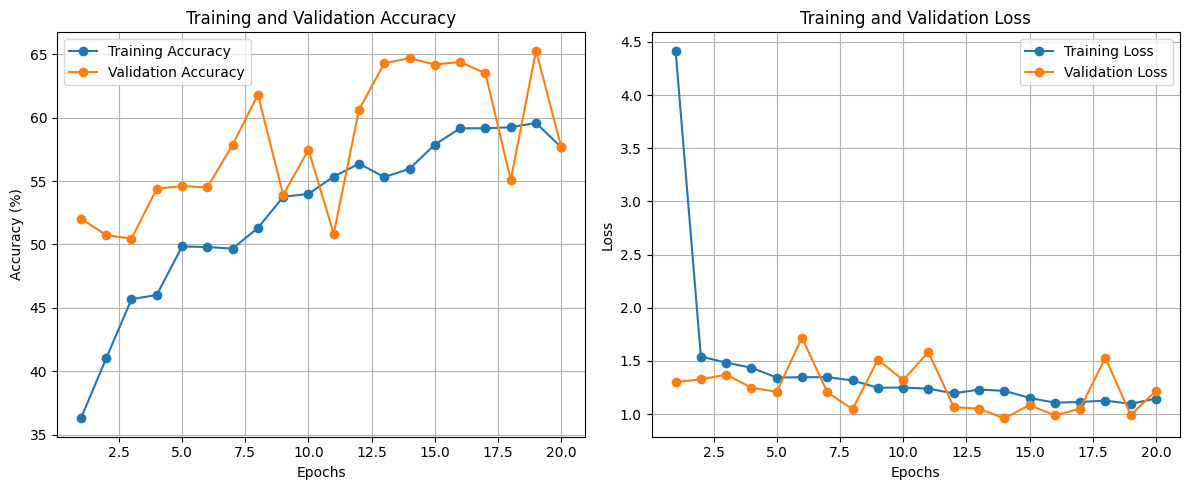

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 21)

# ACCURACY PLOT
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label="Training Accuracy", marker='o')
plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker='o')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()

# VALIDATION PLOT
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label="Training Loss", marker='o')
plt.plot(epochs, val_losses, label="Validation Loss", marker='o')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()


plt.tight_layout()
plt.show()

##### **SAVE THE MODEL**

In [ ]:
torch.save(model, "model_full.pth")

In [13]:
torch.save(model.state_dict(), "model_weights.pth")

In [15]:
from google.colab import files

# Download the weights file
files.download("model_weights.pth")

# Download the full model file
files.download("model_full.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### **IMAGE TESTING**

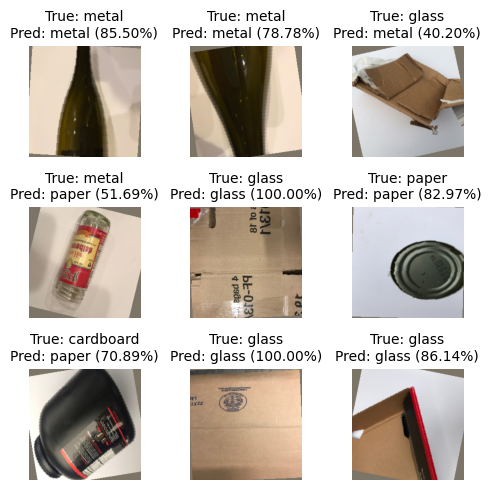

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from random import sample

def preprocess_image(image):
    return image.unsqueeze(0)  


def plot_predictions(dataset, model, class_names, num_images=9, device="cuda"):
    model.eval()  

    indices = sample(range(len(dataset)), num_images)
    selected_samples = [dataset[i] for i in indices]

    plt.figure(figsize=(5, 5))
    for i, (image, true_label) in enumerate(selected_samples):
        
        image_for_prediction = preprocess_image(image).to(device)

        with torch.no_grad():
            outputs = model(image_for_prediction)
            predicted_class = outputs.argmax(dim=1).item()
            confidence = torch.softmax(outputs, dim=1).max().item()
        
        img_np = image.permute(1, 2, 0).numpy()  
        img_np = (img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))  
        img_np = np.clip(img_np, 0, 1)  

        plt.subplot(3, 3, i + 1)
        plt.imshow(img_np)
        plt.title(
            f"True: {class_names[true_label]}\n"
            f"Pred: {class_names[predicted_class]} ({confidence * 100:.2f}%)",
            fontsize=10
        )
        plt.axis("off")

    plt.tight_layout()
    plt.show()


class_names = ['glass', 'metal', 'paper', 'plastic', 'cardboard', 'trash']

plot_predictions(val_dataset, model, class_names, num_images=9, device="cuda")


#### **HUGGINGFACE SETUP**

In [1]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: fineGrained).
The token `jaya-trash` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authentica

In [ ]:
from huggingface_hub import HfApi, upload_file

model_name = "trash-classification-pure-cnn"
repo_id = f"jayaiskandar17/{model_name}"

# CREATE THE REPO
HfApi().create_repo(repo_id=repo_id, exist_ok=True)

# UPLOAD THE MODEL FILE
upload_file(
    path_or_fileobj="model_full.pth",
    path_in_repo="model_full.pth",
    repo_id=repo_id,
    commit_message="Upload full CNN PyTorch model"
)

# UPLOAD THE WEIGHTS FILE
upload_file(
    path_or_fileobj="model_weights.pth",
    path_in_repo="model_weights.pth",
    repo_id=repo_id,
    commit_message="Upload CNN PyTorch model weights"
)

model_full.pth:   0%|          | 0.00/103M [00:00<?, ?B/s]

model_weights.pth:   0%|          | 0.00/103M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/jayaiskandar17/trash-classification-pure-cnn/commit/b34721c452e2bc1a4b9b626e997f6eee99293521', commit_message='Upload CNN PyTorch model weights', commit_description='', oid='b34721c452e2bc1a4b9b626e997f6eee99293521', pr_url=None, repo_url=RepoUrl('https://huggingface.co/jayaiskandar17/trash-classification-pure-cnn', endpoint='https://huggingface.co', repo_type='model', repo_id='jayaiskandar17/trash-classification-pure-cnn'), pr_revision=None, pr_num=None)